In [1]:
import pandas as pd
import numpy as np
import os , shutil
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import zipfile
%matplotlib inline
plt.style.use('ggplot')

Renaming The Files

In [8]:
path_ys='Brain_Tumor_Images/yes/'
cnt=1
for fl_nm in os.listdir(path_ys):
    source=path_ys+fl_nm
    dest=path_ys+"Y_"+str(cnt)+".jpg"
    os.rename(source,dest)
    cnt+=1

In [9]:
path_no='Brain_Tumor_Images/no/'
cnt=1
for fl_nm in os.listdir(path_no):
    source=path_no+fl_nm
    dest=path_no+"N_"+str(cnt)+".jpg"
    os.rename(source,dest)
    cnt+=1

In [10]:
cnt_ys=len(os.listdir('Brain_Tumor_Images/yes/'))
cnt_no=len(os.listdir('Brain_Tumor_Images/no/'))

Text(0.5, 1.0, 'Number of brain Tumor Image')

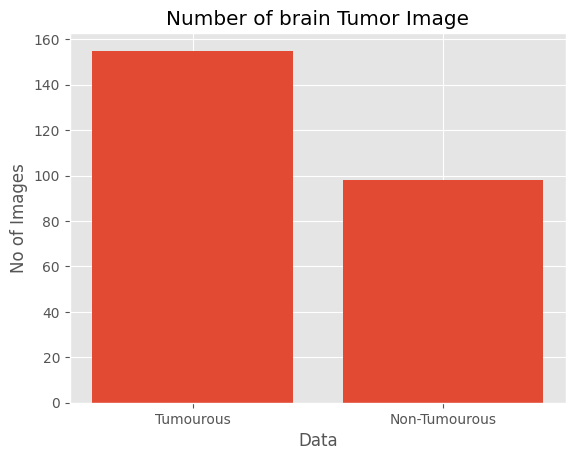

In [14]:
type=["Tumourous","Non-Tumourous"]
value=[cnt_ys,cnt_no]
plt.bar(type,value)
plt.xlabel('Data')
plt.ylabel('No of Images')
plt.title('Number of brain Tumor Image')

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD , Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [3]:
def augment_data(file_dir, n_sample, saving_dir):
    datagen=ImageDataGenerator(rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                brightness_range=(0.3,1.0),
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='nearest')
    for filename in os.listdir(file_dir):
        img=cv2.imread(file_dir+'/'+ filename)
        img=img.reshape((1,)+img.shape)
        save_prefix='aug_'+filename[:-4]
        i=0
        for batch in datagen.flow(x=img,batch_size=1,save_to_dir=saving_dir,save_prefix=save_prefix,save_format='jpg'):
            i+=1
            if i>n_sample:
                break
            


In [20]:
augment_data('Brain_Tumor_Images/yes',6,'Augmented_Data/yes')
augment_data('Brain_Tumor_Images/no',9,'Augmented_Data/no')

In [6]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)
    
    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

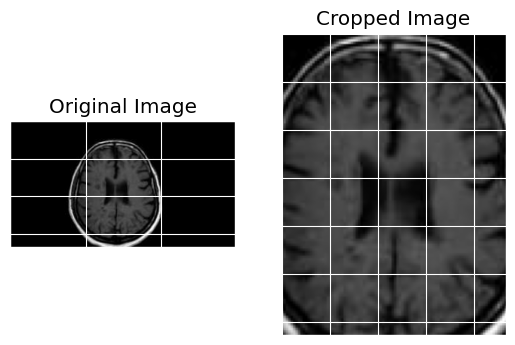

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[102, 102, 102],
        [166, 166, 166],
        [192, 192, 192],
        ...,
        [161, 161, 161],
        [125, 125, 125],
        [ 70,  70,  70]],

       [[ 53,  53,  53],
        [115, 115, 115],
        [156, 156, 156],
        ...,
        [128, 128, 128],
        [ 77,  77,  77],
        [ 28,  28,  28]],

       [[ 20,  20,  20],
        [ 72,  72,  72],
        [123, 123, 123],
        ...,
        [ 79,  79,  79],
        [ 16,  16,  16],
        [  0,   0,   0]]

In [16]:
image=cv2.imread('Augmented_Data/no/aug_N_3_0_1811.jpg')
crop_brain_tumor(image,True)

In [17]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

Train , Test and Validation Split

In [18]:
if not os.path.isdir('Data_Splited'):
    base_dir='Data_Splited'
    os.mkdir(base_dir)

if not os.path.isdir('Data_Splited/train'):
    train_dir=os.path.join(base_dir,'train')
    os.mkdir(train_dir)

if not os.path.isdir('Data_Splited/test'):
    test_dir=os.path.join(base_dir,'test')
    os.mkdir(test_dir)

if not os.path.isdir('Data_Splited/val'):
    val_dir=os.path.join(base_dir,'val')
    os.mkdir(val_dir)

In [19]:
if not os.path.isdir('Data_Splited/train/no'):
    os.mkdir('Data_Splited/train/no')

if not os.path.isdir('Data_Splited/train/yes'):
    os.mkdir('Data_Splited/train/yes')

if not os.path.isdir('Data_Splited/test/no'):
    os.mkdir('Data_Splited/test/no')

if not os.path.isdir('Data_Splited/test/yes'):
    os.mkdir('Data_Splited/test/yes')

if not os.path.isdir('Data_Splited/val/no'):
    os.mkdir('Data_Splited/val/no')

if not os.path.isdir('Data_Splited/val/yes'):
    os.mkdir('Data_Splited/val/yes')

In [21]:
files = os.listdir('augmented_data/yes/')
sz=len(files)
print(sz)

1770


In [22]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,int(sz*0.8)):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join('augmented_data/yes/', fname)
    dst = os.path.join('Data_Splited/train/yes', fname)
    shutil.copyfile(src, dst)


fnames = []
for i in range(int(sz*0.8),int(sz*0.9)):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join('augmented_data/yes/', fname)
    dst = os.path.join('Data_Splited/test/yes', fname)
    shutil.copyfile(src, dst)


fnames = []
for i in range(int(sz*0.9),sz):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join('augmented_data/yes/', fname)
    dst = os.path.join('Data_Splited/val/yes', fname)
    shutil.copyfile(src, dst)

In [23]:
files = os.listdir('augmented_data/no/')
sz=len(files)
print(sz)

980


In [24]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,int(sz*0.8)):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join('augmented_data/no/', fname)
    dst = os.path.join('Data_Splited/train/no', fname)
    shutil.copyfile(src, dst)


fnames = []
for i in range(int(sz*0.8),int(sz*0.9)):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join('augmented_data/no/', fname)
    dst = os.path.join('Data_Splited/test/no', fname)
    shutil.copyfile(src, dst)


fnames = []
for i in range(int(sz*0.9),sz):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join('augmented_data/no/', fname)
    dst = os.path.join('Data_Splited/val/no', fname)
    shutil.copyfile(src, dst)

In [25]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [27]:
train_generator = train_datagen.flow_from_directory('Data_Splited/train/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 2200 images belonging to 2 classes.


In [28]:
test_generator = train_datagen.flow_from_directory('Data_Splited/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 275 images belonging to 2 classes.


In [30]:
valid_generator = train_datagen.flow_from_directory('Data_Splited/val/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 275 images belonging to 2 classes.


In [31]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [32]:
class_name

{0: 'no', 1: 'yes'}

In [33]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [35]:
filepath = 'Model_Weights/model.keras'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [36]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

c:\Users\Rajdeep Das\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [37]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=valid_generator)


Epoch 1/2


c:\Users\Rajdeep Das\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4924 - loss: 0.7913
Epoch 1: val_loss improved from inf to 0.66062, saving model to Model_Weights/model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 187s 19s/step - accuracy: 0.5010 - loss: 0.7871 - val_accuracy: 0.6436 - val_loss: 0.6606 - learning_rate: 1.0000e-04
Epoch 2/2


c:\Users\Rajdeep Das\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6256 - loss: 0.7070
Epoch 2: val_loss improved from 0.66062 to 0.64400, saving model to Model_Weights/model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 184s 19s/step - accuracy: 0.6259 - loss: 0.7058 - val_accuracy: 0.6473 - val_loss: 0.6440 - learning_rate: 1.0000e-04


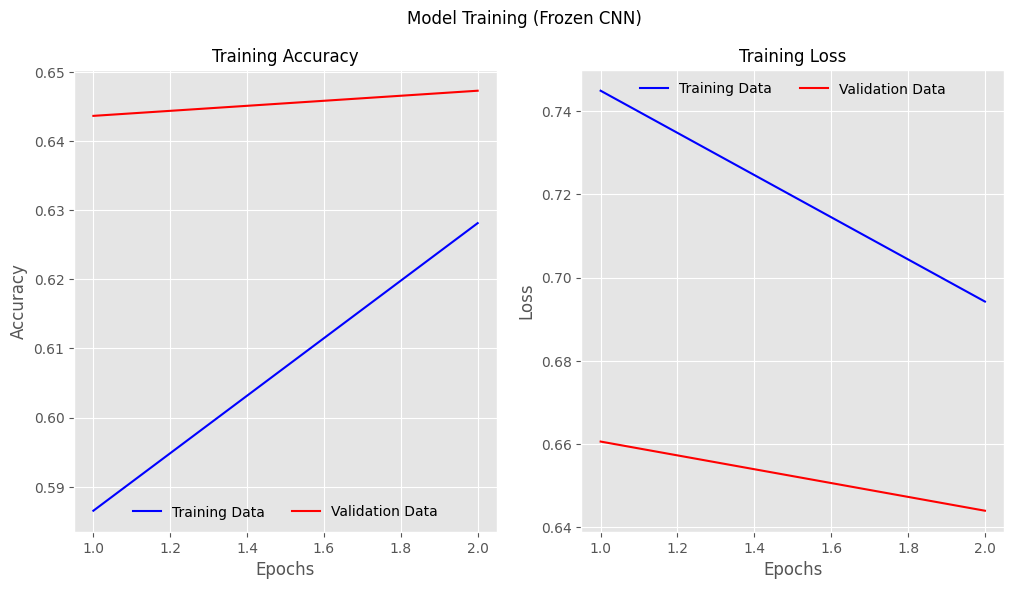

In [39]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [41]:
model_01.save_weights(filepath="Model_Weights/vgg19_model_01.weights.h5", overwrite=True)

In [42]:
model_01.load_weights("Model_Weights/vgg19_model_01.weights.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - accuracy: 0.6159 - loss: 0.6613


c:\Users\Rajdeep Das\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 72s 8s/step - accuracy: 0.6481 - loss: 0.6646


In [43]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.6407629251480103
Validation Acc: 0.6436363458633423
Testing Loss: 0.6685154438018799
Testing Acc: 0.6436363458633423


Incremental Unfreezing and Fine Tuning

In [45]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers] 


In [47]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers] 
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('Model_Weights/vgg19_model_01.weights.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 125,641,602 (479.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [48]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

c:\Users\Rajdeep Das\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [50]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs = 15, callbacks=[es,cp,lrr], validation_data=valid_generator)


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6699 - loss: 0.6321
Epoch 1: val_loss did not improve from 0.64400
10/10 ━━━━━━━━━━━━━━━━━━━━ 177s 18s/step - accuracy: 0.6673 - loss: 0.6352 - val_accuracy: 0.6327 - val_loss: 0.6442 - learning_rate: 1.0000e-04
Epoch 2/15


c:\Users\Rajdeep Das\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5995 - loss: 0.6903 
Epoch 2: val_loss did not improve from 0.64400
10/10 ━━━━━━━━━━━━━━━━━━━━ 188s 20s/step - accuracy: 0.6021 - loss: 0.6880 - val_accuracy: 0.6436 - val_loss: 0.6566 - learning_rate: 1.0000e-04
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6240 - loss: 0.6816 
Epoch 3: val_loss improved from 0.64400 to 0.62426, saving model to Model_Weights/model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 213s 22s/step - accuracy: 0.6227 - loss: 0.6813 - val_accuracy: 0.6545 - val_loss: 0.6243 - learning_rate: 1.0000e-04
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6528 - loss: 0.6630 
Epoch 4: val_loss did not improve from 0.62426
10/10 ━━━━━━━━━━━━━━━━━━━━ 213s 22s/step - accuracy: 0.6551 - loss: 0.6607 - val_accuracy: 0.6400 - val_loss: 0.6419 - learning_rate: 1.0000e-04
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6365 - loss: 0.6369 
Epoch 5: val_loss did not improve from 0.62426
1

c:\Users\Rajdeep Das\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 7: val_loss did not improve from 0.62426
10/10 ━━━━━━━━━━━━━━━━━━━━ 218s 23s/step - accuracy: 0.6883 - loss: 0.6353 - val_accuracy: 0.6436 - val_loss: 0.6302 - learning_rate: 1.0000e-04
Epoch 7: early stopping


In [57]:
model_02.save_weights(filepath="model_weights/vgg19_model_02.weights.h5", overwrite=True)


In [59]:
model_02.load_weights("model_weights/vgg19_model_02.weights.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - accuracy: 0.6610 - loss: 0.6181
9/9 ━━━━━━━━━━━━━━━━━━━━ 72s 8s/step - accuracy: 0.6670 - loss: 0.6520


Unfreezing Entire Network

In [63]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers] 
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights('Model_Weights/vgg19_model_02.weights.h5')

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_03.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

c:\Users\Rajdeep Das\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [64]:
model_03.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 140,946,370 (537.67 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
history_03 = model_03.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=valid_generator)


Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.6526 - loss: 0.6747 
Epoch 1: val_loss improved from 0.62426 to 0.61744, saving model to Model_Weights/model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 506s 51s/step - accuracy: 0.6541 - loss: 0.6728 - val_accuracy: 0.6509 - val_loss: 0.6174 - learning_rate: 1.0000e-04
Epoch 2/2


c:\Users\Rajdeep Das\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.6457 - loss: 0.6457 
Epoch 2: val_loss improved from 0.61744 to 0.61728, saving model to Model_Weights/model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 536s 55s/step - accuracy: 0.6430 - loss: 0.6470 - val_accuracy: 0.6291 - val_loss: 0.6173 - learning_rate: 1.0000e-04


In [66]:
model_03.load_weights("model_weights/vgg_unfrozen.h5")
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 71s 8s/step - accuracy: 0.7538 - loss: 0.6018
9/9 ━━━━━━━━━━━━━━━━━━━━ 73s 8s/step - accuracy: 0.8070 - loss: 0.5219
